In [189]:
# !pip install gglasso

In [191]:
import os
import gglasso
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

from xgboost import XGBClassifier


from matplotlib.pyplot import figure

from numpy.linalg import matrix_rank
from numpy import genfromtxt

from scipy import stats
from scipy.linalg import eigh

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

from gglasso.solver.admm_solver import ADMM_MGL
from gglasso.problem import glasso_problem
from gglasso.helper.data_generation import generate_precision_matrix, group_power_network, sample_covariance_matrix
from gglasso.helper.basic_linalg import adjacency_matrix
from gglasso.helper.data_generation import time_varying_power_network, sample_covariance_matrix
from gglasso.helper.experiment_helper import lambda_grid, discovery_rate, error
from gglasso.helper.utils import get_K_identity
from gglasso.helper.experiment_helper import plot_evolution, plot_deviation, surface_plot, single_heatmap_animation
from gglasso.helper.model_selection import aic, ebic, K_single_grid

In [ ]:
start = 0
stop = 50

sub_corr = []

### on cloud
# for i in range(start, stop):
#     sub_corr.append(genfromtxt("/storage/groups/bds01/datasets/brains/corr_matrices/corr{0}.csv".format(i), delimiter=','))

### on premisis
for i in range(start, stop):
    sub_corr.append(genfromtxt("../data/sub_corr50/sub_corr{0}.csv".format(i), delimiter=','))
    
    

    
sub_corr = np.array(sub_corr)
sub_corr.shape

In [ ]:
lambda1_range = np.logspace(-0.9, -1.5, 2)

N = [sub_corr.shape[1]]*sub_corr.shape[0]


est_uniform, est_indv, statistics = K_single_grid(sub_corr, lambda1_range, N, 
                                                  method = 'eBIC', gamma = 0.3, 
                                                  latent = False, use_block = True)


K = "50"

if not os.path.exists("../data/est_uniform{0}/".format(K)):
    os.mkdir("../data/est_uniform{0}/".format(K))
    
if not os.path.exists("../data/est_individ{0}/".format(K)):
    os.mkdir("../data/est_individ{0}/".format(K))

# dump matrices into csv
for i in range(start, stop):
    np.savetxt("../data/est_uniform{0}/est_uniform{1}.csv".format(K, i), est_uniform["Theta"][i], 
               delimiter=",", header='')
    np.savetxt("../data/est_individ{0}/est_individ{1}.csv".format(K, i), est_indv["Theta"][i], 
               delimiter=",", header='')
    
with open("../data/statistics{0}.txt".format(K), 'w') as f:
    print(statistics, file=f)


### cloud
# os.mkdir("/storage/groups/bds01/datasets/brains/est_uniform{0}/".format(K))
# os.mkdir("/storage/groups/bds01/datasets/brains/est_individ{0}/".format(K))

# # dump matrices into csv
# for i in range(start, stop):
#     np.savetxt("/storage/groups/bds01/datasets/brains/est_uniform{0}/est_uniform{1}.csv".format(K, i), est_uniform["Theta"][i], 
#                delimiter=",", header='')
#     np.savetxt("/storage/groups/bds01/datasets/brains/est_individ{0}/est_individ{1}.csv".format(K, i), est_indv["Theta"][i], 
#                delimiter=",", header='')
    
# with open("statistics{0}.txt".format(K), 'w') as f:
#     print(statistics, file=f)

In [ ]:
est_uniform['Theta'].shape

In [ ]:
sex = pd.read_csv("../data/sex.csv")
age = pd.read_csv("../data/age.csv")

# Logistic regression

In [ ]:
sex_50 = np.array(sex.iloc[:50,])
age_50 = np.array(age.iloc[:50,])

sex_50.shape, age_50.shape

In [ ]:
X, y = est_uniform['Theta'], sex_50

X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('Y_train: ',Y_train.shape)
print('Y_test: ',Y_test.shape)

In [ ]:
# Converting the 3D matrix to 2D matrix
print('X_train: {0}'.format(X_train.shape))
print('X_test: {0} \n'.format(X_test.shape))

n_train = X_train.shape[0]
n_test = X_test.shape[0]

X_train = X_train.reshape(n_train, X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(n_test, X_test.shape[1]*X_test.shape[2])

print("X train flatten: {0}".format(X_train_flatten.shape))
print("X test flatten: {0} \n".format(X_test_flatten.shape))

In [ ]:
# create model and train test accuracy print
logreg = LogisticRegression(random_state = 42, max_iter= 150, penalty='l2')
logreg.fit(X_train, y_train.ravel())
print("Test accuracy: {} ".format(logreg.score(X_test, y_test)))

In [ ]:
predictions = logreg.predict(X_test)

cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(logreg.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

# XGBoost

In [ ]:
xgb_cl = XGBClassifier()
print(type(xgb_cl))

In [ ]:
xgb_cl.fit(X_train, y_train.ravel())

preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

### Benchmarking

training XGBoost
training Log-regression
training SVM


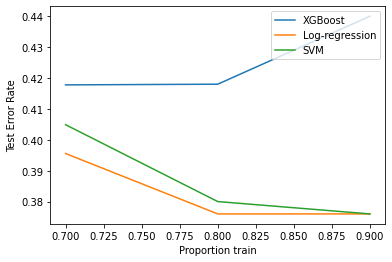

In [192]:
#adjust CV threshold so you don't have only one class in a sample
heldout = [0.3, 0.2, 0.1]
# Number of rounds to fit and evaluate an estimator.
rounds = 10
X, y = est_uniform['Theta'], sex_50

classifiers = [
     ("XGBoost", xgb.XGBClassifier()),
    ("Log-regression", LogisticRegression(max_iter= 110, penalty='l2')),
   ("SVM", svm.SVC(kernel='linear'))
]

xx = 1.0 - np.array(heldout)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=i, random_state=rng
            )
            
            n_train = X_train.shape[0]
            n_test = X_test.shape[0]

            X_train = X_train.reshape(n_train, X_train.shape[1]*X_train.shape[2])
            X_test = X_test.reshape(n_test, X_test.shape[1]*X_test.shape[2])
            
            clf.fit(X_train, y_train.ravel())
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()